### Descripción del proyecto
La empresa data bank ha estado teniendo una baja de clientes de manera mensual, algo muy inusual para ellos. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.
Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 
Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import traceback

In [2]:
#Exploring data
churn_df = pd.read_csv('Churn.csv')
print(churn_df.shape)
print("***********")
print(churn_df.dtypes)
print("***********")
print(churn_df.head(5))

(10000, 14)
***********
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
***********
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               

Características

- RowNumber: índice de cadena de datos
- CustomerId: identificador de cliente único
- Surname: apellido
- CreditScore: valor de crédito
- Geography: país de residencia
-Gender: sexo
- Age: edad
- Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- Balance: saldo de la cuenta
- NumOfProducts: número de productos bancarios utilizados por el cliente
- HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- IsActiveMember: actividad del cliente (1 - sí; 0 - no)
- EstimatedSalary: salario estimado
- Exited: El cliente se ha ido (1 - sí; 0 - no)

In [3]:
#Revise null data 
churn_df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Dentro de los valores nulos podemos observar que la columna "Tenure" es la única con este tipo de valores, posiblemente se deba a que hay clientes que no han tenido depositos a plazos fijos o sean clientes que no han cumplido con el periodo de un año como minimo.

## Analisis eploratorio de los datos


In [4]:
churn_df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


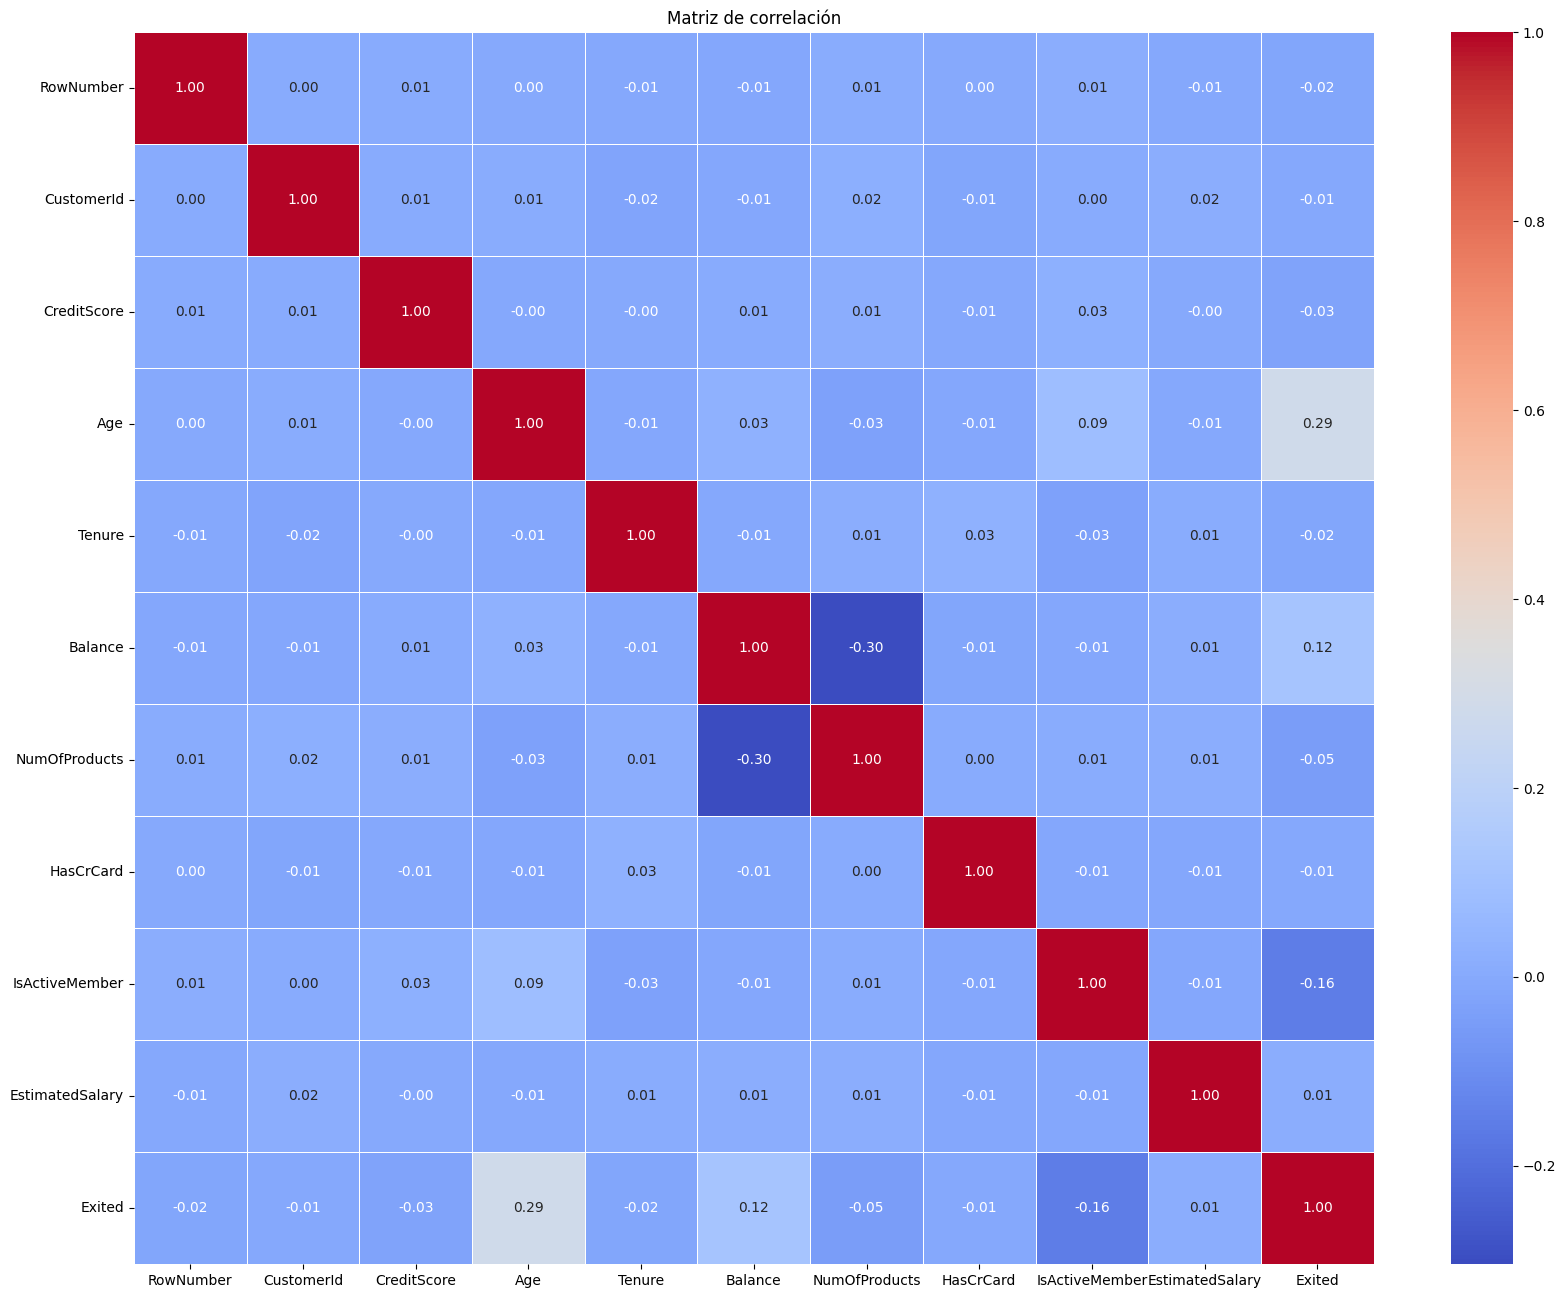

In [5]:
df_copy = churn_df.copy()  # Evitar modificar el DataFrame original
df_num = df_copy.select_dtypes(include='number')
corr_matrix = df_num.corr()

# Crear la figura correctament
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show() 


Dentro de la prueba de correlación podemos encontrar lo siguiente:

- Balance y NumOfProducts tienen una correlación negativa notable (-0.30 aprox.), lo que sugiere que a medida que aumenta el número de productos, el balance tiende a reducirse.
- CreditScore y Age tienen una correlación baja (alrededor de 0.29), lo que indica que a medida que aumenta la edad, el puntaje de crédito podría subir ligeramente.
- Exited (variable objetivo) tiene una correlacion positiva con la colunma Age, puede indicarnos que con el aumento de Edad los clientes tiendan a dejar los servicios del banco

In [6]:
age_country = churn_df.groupby('Geography')[['Age','Exited']].mean().reset_index()
print(age_country)

  Geography        Age    Exited
0    France  38.511767  0.161548
1   Germany  39.771622  0.324432
2     Spain  38.890997  0.166734


<Axes: xlabel='CreditScore', ylabel='Geography'>

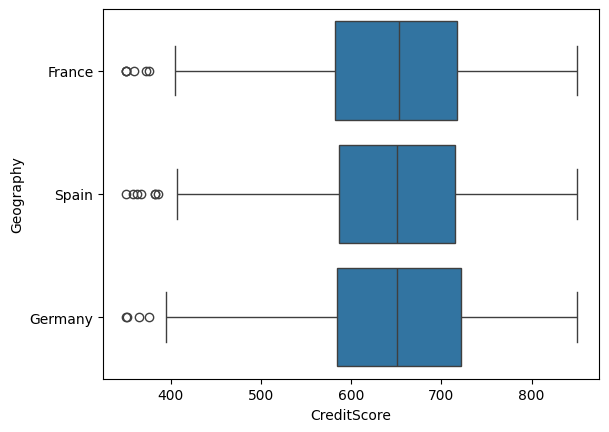

In [7]:
sns.boxplot(data=churn_df, x="CreditScore", y="Geography")

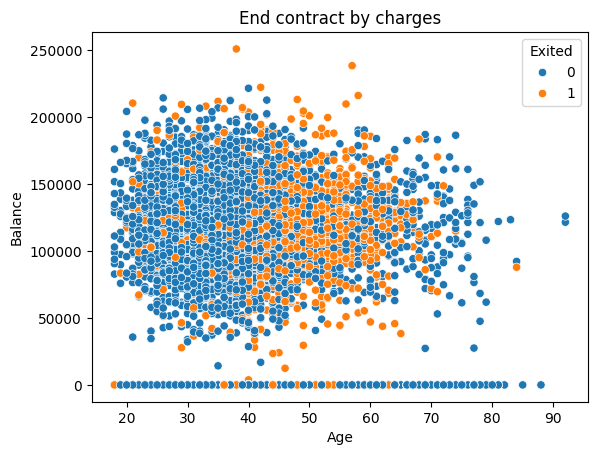

In [17]:
sns.scatterplot(x='Age', y='Balance', hue='Exited', data=churn_df)
plt.title('End contract by charges')
plt.show()
plt.show()

La media de las personas que cancelan su servicio se tiene entre 45 a 60 años 

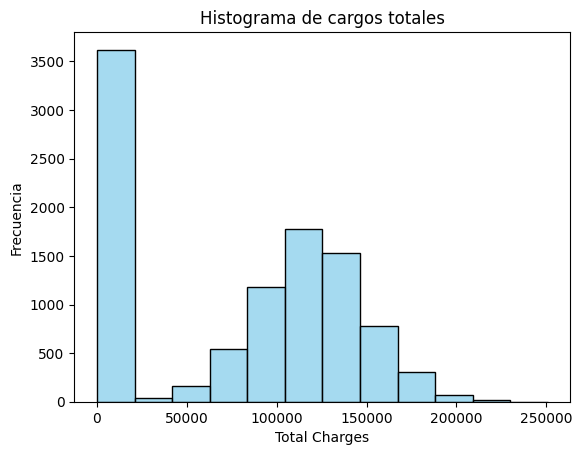

In [9]:
sns.histplot(churn_df['Balance'], bins=12, kde=False, color='skyblue', edgecolor='black')
plt.title('Histograma de cargos totales')
plt.xlabel('Total Charges')
plt.ylabel('Frecuencia')
plt.show()

Exited
0    7963
1    2037
Name: count, dtype: int64


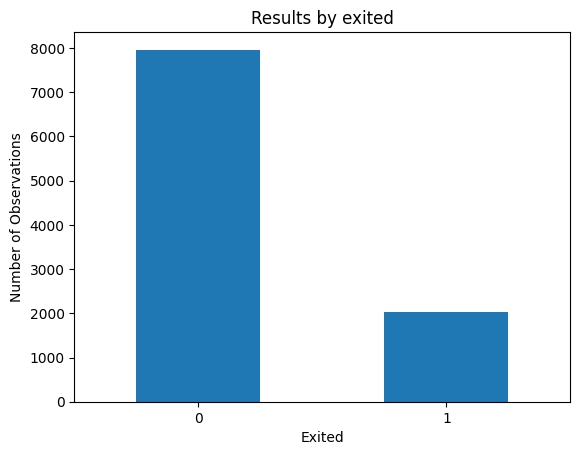

In [10]:
#Plot our minority class
count_classes = churn_df['Exited'].value_counts(sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Results by exited")
plt.xlabel("Exited")
plt.ylabel("Number of Observations")
print(count_classes)

Se encuentran datos con desbalanceo, siendo la clase 1 minoritaria afectando la predicción de los datos. 

## Prepocesamiento de datos.
El siguiente paso es realizar técnicas de imputación para llenar los valores faltantes y feature engineering para las caracteristicas categoricas y numericas.

In [11]:
def preprocess_data_with_imputation(df, n_neighbors=5, random_state=42):
    """
    Parameters:
    X (pd.DataFrame): Features
    y (pd.Series): Target
    n_neighbors (int): neighbors to KNNImputer
    random_state (int): random seed
    """
    try:
        X = df.drop(columns=['RowNumber','CustomerId','Surname'],axis=1)
        y = df['Exited']
        
        # 1. Split inicial
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, 
            test_size=0.2,  # 10% test + 10% validación
            random_state=random_state,
            stratify=y  # Mantener proporción de clases
        )
        
        # 3. Dividir conjunto temporal en test y validación
        X_test, X_val, y_test, y_val = train_test_split(
            X_temp, y_temp,
            test_size=0.5,  # 50% de X_temp equivale a 10% del total
            random_state=random_state,
            stratify=y_temp  # Mantener proporción de clases
        )
        
        # 3. Identificar tipos de columnas
        cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
        num_cols = X_train.select_dtypes(include="number").columns.tolist()

        # 4. Pipelines
        cat_transformer = Pipeline([
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])

        num_transformer = Pipeline([
            ("knn_imputer", KNNImputer(n_neighbors=n_neighbors)),
            ("scaler", StandardScaler()),
        ])

        # 5. ColumnTransformer
        preprocessor = ColumnTransformer([
            ("cat", cat_transformer, cat_cols),
            ("num", num_transformer, num_cols)
        ], remainder="passthrough")
        
         # 6. Aplicar transformaciones
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        X_val_processed = preprocessor.transform(X_val)
        
        # 8. Aplicar SMOTE en el conjunto de entrenamiento
        smote = SMOTE(random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

        return X_train_balanced, y_train_balanced, X_test_processed, y_test, X_val_processed, y_val, preprocessor

        
    except Exception as e:
        print(f"Error crítico: {str(e)}")
        print("Detalles del error:")
        import traceback
        print(traceback.format_exc())  # Muestra el traceback completo
        return None, None, None, None, None, None, None

In [12]:
X_train_balanced, y_train_balanced, X_test_processed, y_test, X_val_processed, y_val, preprocessor = preprocess_data_with_imputation(churn_df, n_neighbors=5, random_state=42)

## Selección de modelo 
Para metodos practicos, se escogieron dos modelos que se han visto en este sprint (Regresion Logistica) y (Arbol de decision)

Escoger los mejores hiperparámetros que no generen ruido y sobreajuste a la predicción usando las librerias GridSearchCV y RandomizedSearchCV 

In [13]:
def train_model(model_name, X_train, y_train, X_test, y_test):
    try:
        # 1. Modelos disponibles
        models = {
            "model_1": LogisticRegression(),
            "model_2": RandomForestClassifier()
        }
        
        if model_name not in models:
            raise ValueError("El modelo seleccionado no es válido. Usa 'model_1' o 'model_2'.")

        model = models[model_name]

        # 2. Hiperparámetros según el modelo
        if model_name == "model_1":  # Logistic Regression
            param_distributions = {
                'penalty': ['l1', 'l2'],
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'saga']
            }
        elif model_name == "model_2":  # Random Forest
            param_distributions = {
                'n_estimators': randint(50, 300),
                'max_depth': randint(5, 50),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'bootstrap': [True, False]
            }

        # 3. Configurar RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,
            scoring='accuracy',
            cv=5,
            verbose=2,
            random_state=42,
            n_jobs=-1
        )

        # 4. Ajustar el modelo
        random_search.fit(X_train, y_train)

        # 5. Mostrar resultados
        print("Mejores hiperparámetros:", random_search.best_params_)
        print("Mejor puntuación obtenida:", random_search.best_score_)

        # 6. Evaluar en el conjunto de prueba
        best_model = random_search.best_estimator_
        test_score = best_model.score(X_test, y_test)
        print("Precisión en el conjunto de prueba:", test_score)
        y_pred = best_model.predict(X_test)

        # Calcular F1-score
        f1 = f1_score(y_test, y_pred)
        print("F1-score:", f1)
        # Suponiendo que ya tienes y_test y y_pred
        print(classification_report(y_test, y_pred))    

        return best_model, test_score

    except Exception as e:
        print(f"Error crítico: {str(e)}")
        print("Detalles del error:")
        print(traceback.format_exc())  # Muestra el traceback completo
        return None, None

In [14]:
model_lr, _ = train_model('model_1',X_train_balanced, y_train_balanced, X_test_processed, y_test) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Mejor puntuación obtenida: 1.0
Precisión en el conjunto de prueba: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       796
           1       1.00      1.00      1.00       204

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [15]:
model_rf, _ = train_model('model_2',X_train_balanced, y_train_balanced, X_test_processed, y_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 33, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}
Mejor puntuación obtenida: 1.0
Precisión en el conjunto de prueba: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       796
           1       1.00      1.00      1.00       204

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



Generamos las matrices de confusión y las metricas de las clases para la precision, recall, y F1 score. Todos generados de las pruebas de validación 

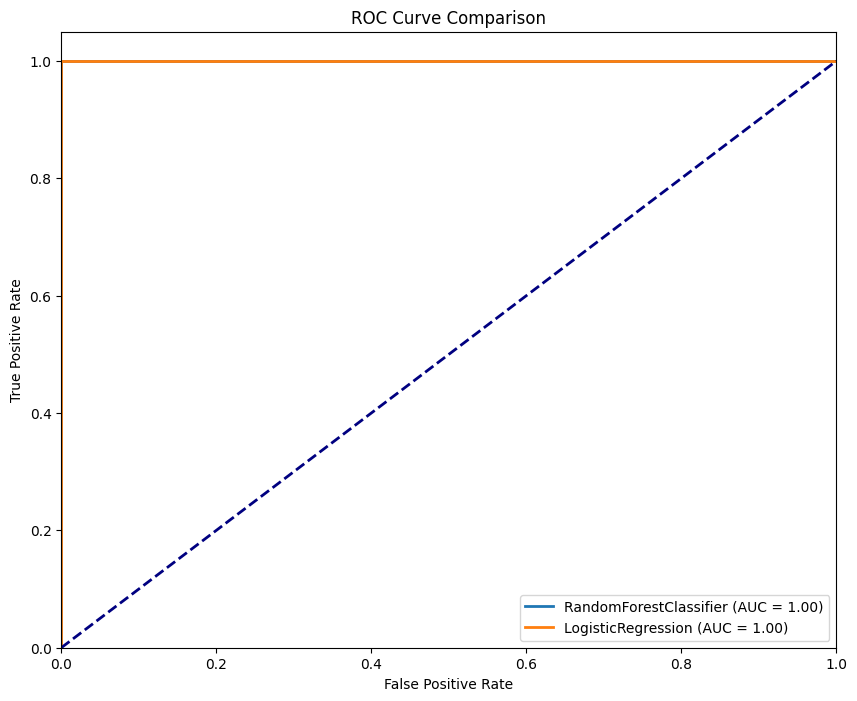

RandomForestClassifier: AUC - ROC = 1.00
LogisticRegression: AUC - ROC = 1.00


In [16]:
models = {
    'RandomForestClassifier': model_rf,
    'LogisticRegression': model_lr,
}

# Initialize a dictionary to store AUC - ROC scores
roc_auc_scores = {}

# Plot the ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict the probabilities
    y_probs = model.predict_proba( X_val_processed)[:, 1]
    
    # Calculate the AUC - ROC score
    roc_auc = roc_auc_score(y_val, y_probs)
    roc_auc_scores[name] = roc_auc
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.2f}')

## Conclusiones generales.
- El modelo llego al máximo rendimiento posible, esto aplicando técnicas de prepocesamiento e imputación ambos modelos tienen la capacidad para saber dividir las clases positivas y negativas.
- El f1-score nos muestra que el modelo supo encontrar tanto los verdaderos positivos como los negativos.
- El modelo de regresión logistica tuvo un rendimeinto más rapido para realizar el entrenamiento.